In [1]:
import os, sys
currentdir = os.path.dirname(os.path.realpath(os.path.abspath("")))
scriptsdir = os.path.dirname(currentdir)
if scriptsdir not in sys.path:
    sys.path.append(scriptsdir)

from customscripts import configuration
from customscripts import utils

# Common imports

import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
human_formatter = ticker.FuncFormatter(utils.human_format)
%reload_ext autoreload
%autoreload 2

In [2]:
data_food = utils.get_dataset_df(3, "all_categories").drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Unnamed: 0.1.1", "Unnamed: 0.1.1.1", "Trade Flow Code", "Commodity", "Reporter", "Reporter Code", "Partner", "Partner Code", 'Development Category',
       'Development Level', 'Population in 2005 (in million)',
       'Population in 2010 (in million)', 'Population in 2014 (in million)',
       'Population in 2018 (in million)',
       '% Malnutritioned Childern < 5 years old', 'Total Imports in $',
       'Income Index Rank', 'ii2005', 'ii2006', 'ii2007', 'ii2008', 'ii2009',
       'ii2010', 'ii2011', 'ii2012', 'ii2013', 'ii2014', 'ii2015', 'ii2016',
       'ii2017', 'ii2018', "Qty", "Netweight (kg)", "Qty Unit Code", "Qty Unit", "Classification"])
data_food = data_food[data_food["Trade Flow"] == "Import"].reset_index()
data_food["Year"] = pd.to_datetime(data_food["Year"], format="%Y")
data_food["Trade Value (US$)"] = data_food["Trade Value (US$)"].astype(float)
data_food["Category Code"] = data_food["Category Code"].astype(int)
data_food["Commodity Code"] = data_food["Commodity Code"].astype(int)

data_indicators = utils.get_dataset_df(4, "all_indicators").drop(columns=["Country Name"]).melt(id_vars=["Country Code", "Series Name"], var_name="Year", value_name="Value")
data_indicators = data_indicators[(~data_indicators["Country Code"].isna() & (data_indicators["Year"] != "Series Code") & (~data_indicators["Series Name"].isna()))].reset_index(drop=True)
data_indicators["Year"] = pd.to_datetime(data_indicators["Year"], format="%Y")
data_indicators = data_indicators.replace({"Value": {"..": np.nan}})
data_indicators["Value"] = data_indicators["Value"].astype(float)

data_misc = utils.get_dataset_df(6, "all_misc_data").drop(columns=["Unnamed: 0"])
data_misc["Time"] = pd.to_datetime(data_misc["Time"], format="%Y-%m-%d")

# Using old, smaller dataset for categories
data_categories = utils.get_dataset_df(4, "final").drop(columns=["Unnamed: 0", "Unnamed: 0.1", "Classification", "Trade Flow Code", "Reporter Code", "Partner Code", "Reporter", "Partner", "GDP Growth % in 2007", "GDP Growth % in 2008", "GDP Growth % in 2009", "GDP Growth % in 2010", "GDP Growth % in 2011", "GDP Growth % in 2012", "GDP Growth % in 2013", "GDP Growth % in 2014", "GDP Growth % in 2015", "GDP Growth % in 2016", "GDP Growth % in 2017", "GDP Growth % in 2018", "GDP Growth % in 2019", 'Population in 2005 (in million)', 'Population in 2010 (in million)', 'Population in 2014 (in million)', 'Population in 2018 (in million)', "Development Category", "Development Level", "Year", "Trade Flow", "Partner ISO", "Reporter ISO", "Trade Value (US$)"]).drop_duplicates().reset_index(drop=True)
data_categories = data_categories.dropna(subset=["Commodity Code"])
data_categories["Commodity Code"] = data_categories["Commodity Code"].astype(str)
data_categories = data_categories.replace({"Commodity Code": { "(\d+)\.0" : r"\1" }}, regex=True)

data_population = utils.get_dataset_df(4, "population").drop(columns=["Indicator Name", "Indicator Code", "Country Name", "2020", "Unnamed: 65"]).melt(id_vars=["Country Code"], var_name="Year", value_name="Population")
data_population = data_population[~data_population["Population"].isna()].reset_index(drop=True)

data_production = utils.get_dataset_df(6, "mineral-production/2008-2018-production-main-minerals")

In [15]:
data_production_cement = data_production[data_production["Sub-commodity"].isin(["Cement, finished"])].groupby(["Sub-commodity", "Year"])["Production (metric tonnes)"].sum().reset_index()
data_production_cement["Year"] = pd.to_datetime(data_production_cement["Year"], format="%Y")
data_production_cement.index = data_production_cement["Year"]
data_production_cement

,Sub-commodity,Year,Production (metric tonnes)
Year,,,
2008-01-01,"Cement, finished",2008-01-01,311680680.0
2009-01-01,"Cement, finished",2009-01-01,261534852.0
2010-01-01,"Cement, finished",2010-01-01,270691270.0
2011-01-01,"Cement, finished",2011-01-01,272384714.0
2012-01-01,"Cement, finished",2012-01-01,251727540.0
2013-01-01,"Cement, finished",2013-01-01,248265078.0
2014-01-01,"Cement, finished",2014-01-01,249631100.0
2015-01-01,"Cement, finished",2015-01-01,244908243.0
2016-01-01,"Cement, finished",2016-01-01,252108652.0


In [5]:
data_misc_cat_mean = data_misc.groupby(["Time", "Reporter", "Category Code"])["Trade Value (US$)"].mean().reset_index()
data_misc_cat_mean.index = data_misc_cat_mean["Time"]

In [6]:
def plot_country_misc(df, country):
    sns.relplot(data=df[df["Reporter"] == country], x="Time", y="Trade Value (US$)", hue="Category Code", palette=["b", "r", "g"])

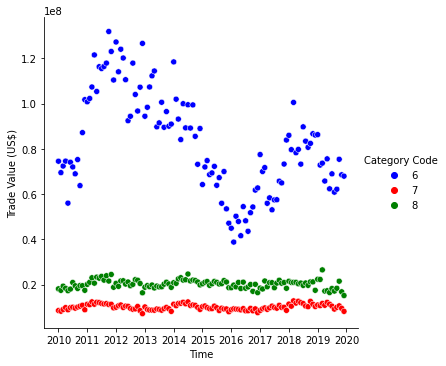

In [7]:
plot_country_misc(data_misc_cat_mean, "GBR")

In [8]:
def plot_country_cat(df, country, cat):
    sns.lineplot(data=df[(df["Reporter"] == country) & (df["Category Code"] == cat)], x="Time", y="Trade Value (US$)", hue="Category Code", palette=["b"])

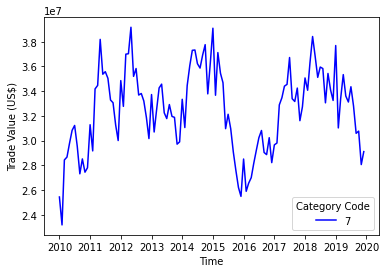

In [9]:
plot_country_cat(data_misc_cat_mean, "USA", 7)

In [11]:
def plot_every_country_cat(df):
    sns.relplot(data=df, x="Time", y="Trade Value (US$)", col="Reporter", hue="Category Code", kind="line", col_wrap=4, facet_kws={"sharey": False, "sharex": True}, palette=["b", "r", "g"])

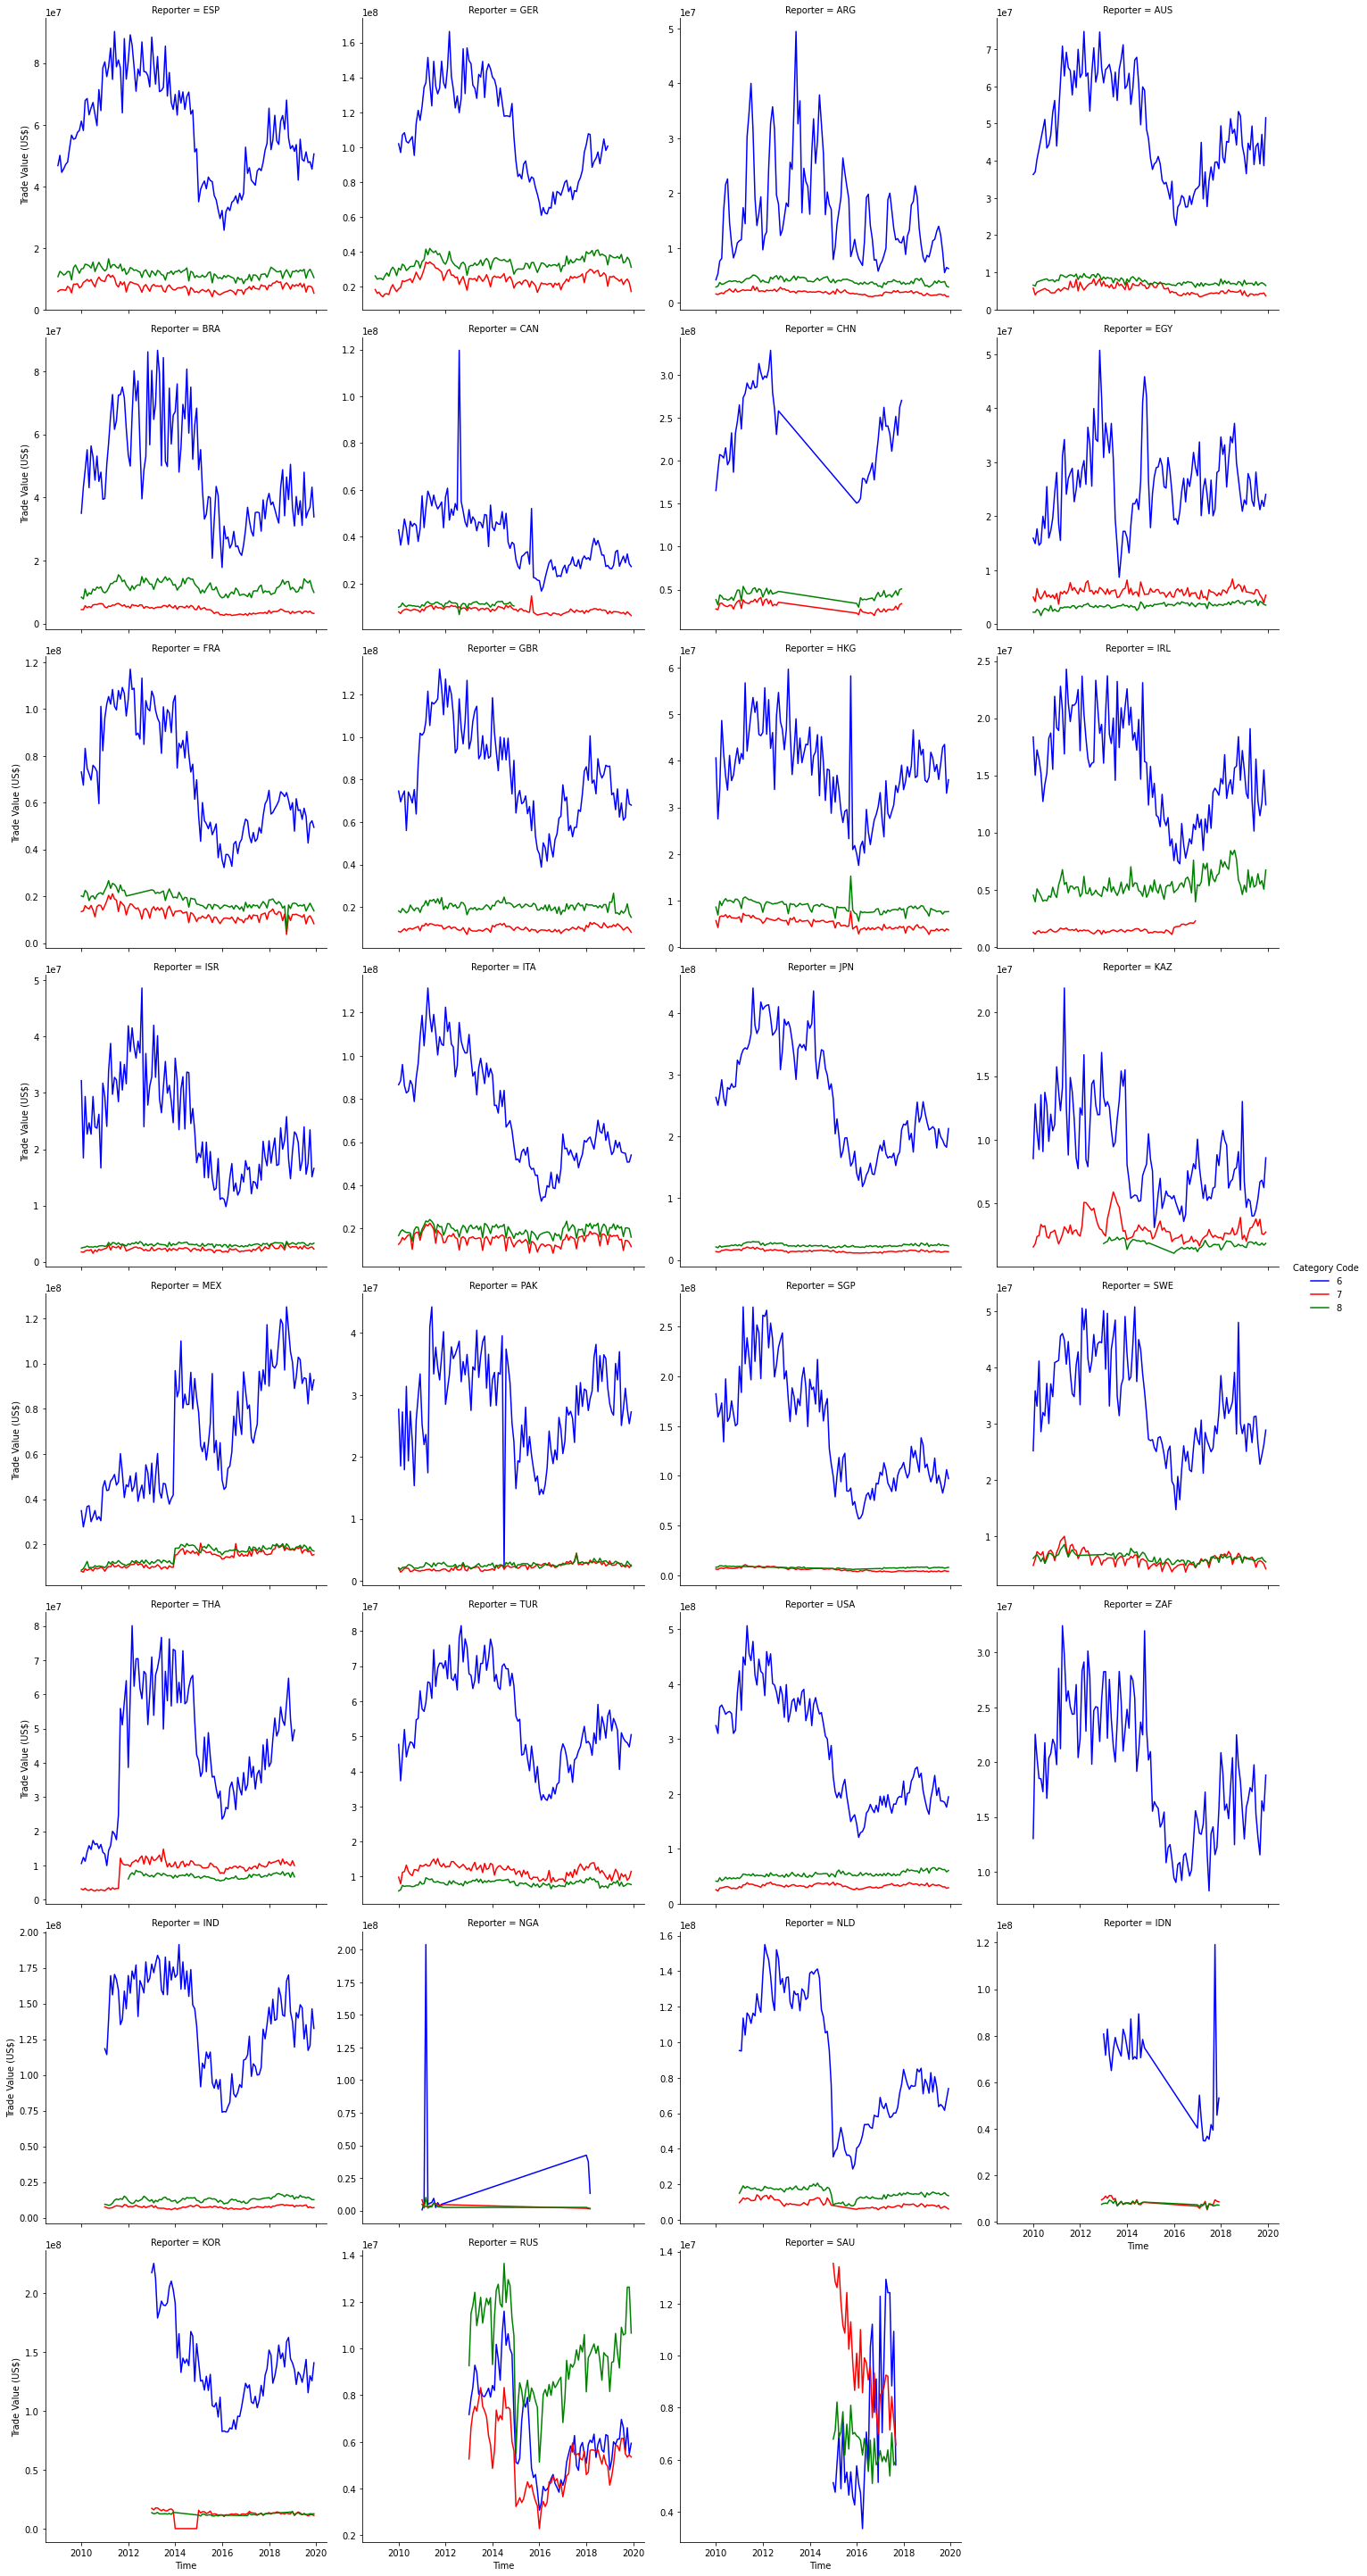

In [12]:
plot_every_country_cat(data_misc_cat_mean)

# SARIMA

We will use the SARIMA model.

ARIMA because we want to analyze and forecast a time series data, in our case, our focus will be on specific countries (the ones with more data available), and in particular we will try to predict specific category data, Plastics (cat8).

What we would like to do is to predict the average price of plastics for said countries.

First of all, we have to analyze the time series by using Autocorrelation functions (ACF) and Partial Autocorrelation functions (PACF).


# ACF

First of all, we want to calculate the ACF of our time series.


In [28]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, pacf
from pandas.plotting import autocorrelation_plot
from sklearn.model_selection import train_test_split
from time import time
from statsmodels.tsa.statespace.sarimax import SARIMAX

# data_misc_cat_mean[data_misc_cat_mean["Reporter"] == "USA"][data_misc_cat_mean["Category Code"] == 8]["Trade Value (US$)"]

def plot_acf_country_cat(df, country, cat):
    # print(df[df.index.duplicated()])
    data = df[df["Reporter"] == country]
    data = data[data["Category Code"] == int(cat)]["Trade Value (US$)"]
    first_diff = data.diff()[1:]
    plot_acf(first_diff)
    plt.show()

def plot_pacf_country_cat(df, country, cat):
    data = df[df["Reporter"] == country]
    data = data[data["Category Code"] == int(cat)]["Trade Value (US$)"]
    first_diff = data.diff()[1:]
    plot_pacf(first_diff, lags=20)
    plt.show()

def model_country_cat(df, country, cat1, cat2, order=(), seasonal_order=(), test_size=0.2):
    data = df[df["Reporter"] == country]
    data = data[data["Category Code"] == int(cat1)]

    data_2 = df[df["Reporter"] == country]
    data_2 = data_2[data_2["Category Code"] == int(cat2)]

    first_diff = data["Trade Value (US$)"].diff()[1:]
    first_diff_2 = data_2["Trade Value (US$)"].diff()[1:]

    X_train = data[(data["Time"] >= "2009") & (data["Time"] < "2018")]["Trade Value (US$)"]
    X_test = data[data["Time"] >= "2018"]["Trade Value (US$)"]

    X_train_2 = data_2[(data_2["Time"] >= "2009") & (data_2["Time"] < "2018")]["Trade Value (US$)"]
    X_test_2 = data_2[data_2["Time"] >= "2018"]["Trade Value (US$)"]

    model = SARIMAX(X_train, X_train_2, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()

    print(model_fit.summary())

    return model_fit, X_test_2



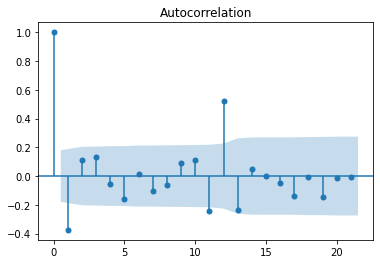

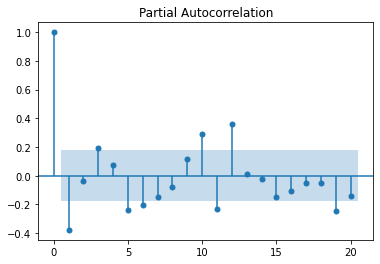

In [18]:
country = "USA"
cat = 7
plot_acf_country_cat(data_misc_cat_mean, country, cat)
plot_pacf_country_cat(data_misc_cat_mean, country, cat)

ACF found us that there's a significant lag every 6 months for cat8 country USA.
Based on the ACF, we should start with a seasonal MA process.



In [48]:
# order: p = 0 or 1 or 2 or 3
# order: q = 1 or 2
# order: d = 0, no trend
model_fit, exog = model_country_cat(data_misc_cat_mean, country, cat, 8, order=(0, 1, 0), seasonal_order=(1, 1, 0, 6), test_size=0.2)

                                     SARIMAX Results                                     
Dep. Variable:                 Trade Value (US$)   No. Observations:                   96
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 6)   Log Likelihood               -1415.007
Date:                           Tue, 19 Jan 2021   AIC                           2836.014
Time:                                   10:33:58   BIC                           2843.480
Sample:                               01-01-2010   HQIC                          2839.023
                                    - 12-01-2017                                         
Covariance Type:                             opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Trade Value (US$)     0.2683      0.043      6.256      0.000       0.184       0.352
ar.S.L6              -

<AxesSubplot:xlabel='Time', ylabel='Trade Value (US$)'>

<AxesSubplot:xlabel='Time', ylabel='Trade Value (US$)'>

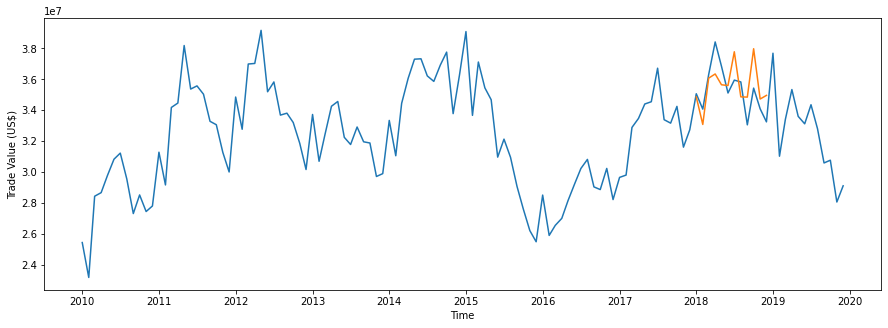

In [54]:
pred_forecast = model_fit.get_forecast(steps=12, exog=exog[:12])

# plot predictions
fig, ax = plt.subplots(figsize=(15, 5))
data_tmp = data_misc_cat_mean[data_misc_cat_mean["Reporter"] == country]
data_tmp = data_tmp[data_tmp["Category Code"] == cat]
sns.lineplot(data=data_tmp, x="Time", y="Trade Value (US$)", ax=ax)
pred_forecast_data = pred_forecast.summary_frame()
sns.lineplot(data=pred_forecast_data, y="mean", x=pred_forecast_data.index, ax=ax)
# ax.fill_between(sar_pred_ci.index, sar_pred_ci.iloc[:, 0], sar_pred_ci.iloc[:, 1], color='k', alpha=.1)

<AxesSubplot:ylabel='mean_se'>

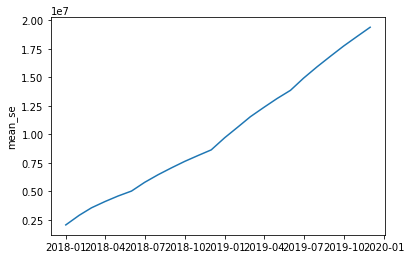

In [51]:
# pred_forecast_data
sns.lineplot(data=pred_forecast_data, y="mean_se", x=pred_forecast_data.index)
